In [ ]:
!pip3 install openai 

In [35]:
import pandas as pd
import numpy as np
import openai
import pickle
import sqlite3
from datasets import Dataset, load_from_disk, DatasetDict
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score, precision_score, recall_score
from metrics_wrapper import ChatGPTMetricsWrapper

In [23]:
conn = sqlite3.connect("data/chatgpt_raw.db")
with conn:
    cur = conn.cursor()
    if conn.execute("SELECT * FROM sqlite_master;").fetchall() == []:
        conn.execute(
            "CREATE TABLE completions("
            "id INTEGER UNIQUE PRIMARY KEY,"
            "completion BLOB);"
        )
        conn.commit()

In [24]:
test_arr = load_from_disk("datasets/familjeliv_testset/")["test"]["text"]
len(test_arr)

978

I stored the OpenAI key in a file named OPENAI_API

In [10]:
openai.api_key_path = "OPENAI_API"

In [37]:
def chatgpt_annotate(arr):
    with open("data/chatgpt_raw.db"):
        for i, post in enumerate(arr):
            conditional = conn.execute(f"SELECT * FROM completions WHERE id={i};")
            if len(conditional.fetchall()) == 0:
                print(f"{i+1}/{len(arr)}", end="\r")
                prompt = "You are an annotator in a linguistic study, where your task is to identify whether the post provided is hate speech or not. You will only respond with the corresponding label, 1 for hate speech, and 0 if it is not hate speech."
                completion = openai.ChatCompletion.create(
                    model="gpt-3.5-turbo",
                    messages=[
                        {"role": "user", "content": f"{prompt}\nPOST: \"{post}\""}
                    ],
                    temperature=0.2,
                )
                completion_pkl = pickle.dumps(completion)
                conn.execute("INSERT INTO completions (id, completion) VALUES (?, ?);", (i, completion_pkl))
                conn.commit()

In [43]:
chatgpt_annotate(test_arr)

In [5]:
conn = sqlite3.connect("data/chatgpt_raw.db")
chatgpt_annotations = list()
with conn:
    for i in conn.execute("SELECT * FROM completions;").fetchall():
        unpkl = pickle.loads(i[1])
        chatgpt_annotations.append(unpkl)

In [6]:
y_pred = [x.choices[0]["message"]["content"] for x in chatgpt_annotations]
for i, x in enumerate(y_pred):
    if "1" in x:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
y_true = [int(x) for x in load_from_disk("datasets/familjeliv_testset/")["test"]["label"]]

In [39]:
text_arr = load_from_disk("datasets/familjeliv_testset/")["test"]["text"]
prediction_wrapper = list(zip(text_arr, y_true, y_pred))
chatgpt_metrics_wrapper = ChatGPTMetricsWrapper(
    f1_score(y_true, y_pred),
    precision_score(y_true, y_pred),
    recall_score(y_true, y_pred),
    confusion_matrix(y_true, y_pred),
    prediction_wrapper
)

precision: 0.24
recall: 0.43
f1_score: 0.30


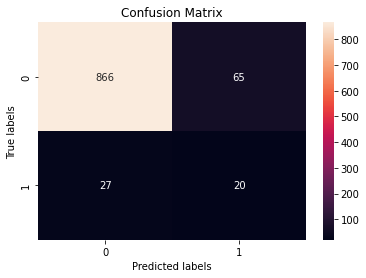

In [40]:
chatgpt_metrics_wrapper.display_metrics()

In [41]:
with open("metrics/familjeliv_chatgpt_metrics.pkl", "wb") as f:
    pickle.dump(chatgpt_metrics_wrapper, f)

The cell below is for manually exploring the annotations

In [ ]:
X = load_from_disk("datasets/familjeliv_testset/")["test"]["text"]

for i, x in enumerate(zip(y_true, y_pred)):
    if x[1] == 0 and x[0] == 1:
        print(X[i])
        print("\n### POST DIVIDER ###\n")